In [1]:
import pandas as pd
import os
from Book_module.Book import Book
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# Initialize an empty list to store data for each story
data = []

# Path to the folder containing your stories
stories_folder = 'books'

# List all story files
story_files = [f for f in os.listdir(stories_folder) if f.endswith('.txt')]

# Dictionary mapping story filenames to perpetrators
# Replace this with your actual data
story_perpetrators = {
    'book_bottomless_well.txt': 'Harrison',
    'book_eye_of_apollo.txt': 'Kevin',
    'book_face_in_the_target.txt' : 'Jenkins',
    'book_fad_of_the_fisherman.txt' : 'Merivale',
    'book_hole_in_the_wall.txt' : 'Haddow',
    'book_secret_garden.txt' : 'Valentin',
    'book_sign_of_the_broken_sword.txt' : 'Arthur',
    'book_soul_of_schoolboy.txt' : 'Morty',
    'book_temple_of_silence.txt' : 'Verner',
    'book_the_blue_cross.txt' : 'Hercule',
    'book_the_flying_stars.txt' : 'Hercule',
    'book_the_hammer_of_god.txt' : 'Wilfred',
    'book_the_queer_feet.txt' : 'Hercule',
    'book_the_sins_of_prince_saradine.txt' : 'Saradine',
    'book_the_wrong_shape.txt' : 'Harris',
    'book_three_tools_of_death.txt' : 'Aaron',
    'book_vanishing_prince.txt' : 'Wilson',
    'book_vengeance_of_the_statue.txt' : 'Horne'
    # Add all stories and their perpetrators
}

for story_file in story_files:
    file_path = os.path.join(stories_folder, story_file)
    book = Book(file_path)
    book.pre_process()
    book.feature_extraction()
    
    # Get the perpetrator for this story
    perpetrator = story_perpetrators.get(story_file)
    if perpetrator is None:
        print(f"No perpetrator found for {story_file}. Skipping.")
        continue
    
    # Features related to the perpetrator
    perp_mention_count = book.character_mentions_all.get(perpetrator, 0)
    perp_first_mention = book.character_mentions_first.get(perpetrator, -1)
    perp_sentiment = book.character_sentiments.get(perpetrator, 0)
    
    # Rank of the perpetrator by mentions
    mentions_sorted = sorted(book.character_mentions_all.items(), key=lambda x: x[1], reverse=True)
    perp_rank = next((rank for rank, (name, _) in enumerate(mentions_sorted, 1) if name == perpetrator), None)
    
    # Total number of characters
    total_characters = len(book.names)
    
    # Average character mention count
    avg_mention_count = sum(book.character_mentions_all.values()) / total_characters if total_characters > 0 else 0
    
    # Crime first introduction
    crime_first_intro = book.crime_first_introduction
    
    # Is the perpetrator introduced before the crime?
    perp_introduced_before_crime = perp_first_mention < crime_first_intro if crime_first_intro != -1 else False
    
    # Proximity features
    perp_proximity_score = sum(count for (char1, char2), count in book.character_proximity.items() if perpetrator in (char1, char2))
    
    # Prepare the row data
    row = {
        'Story': story_file,
        'Perpetrator': perpetrator,
        'Perp_Mention_Count': perp_mention_count,
        'Perp_First_Mention': perp_first_mention,
        'Perp_Sentiment': perp_sentiment,
        'Perp_Rank': perp_rank,
        'Total_Characters': total_characters,
        'Avg_Mention_Count': avg_mention_count,
        'Crime_First_Introduction': crime_first_intro,
        'Perp_Introduced_Before_Crime': perp_introduced_before_crime,
        'Perp_Proximity_Score': perp_proximity_score,
        # Add more features as needed
    }
    
    data.append(row)

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

[__init__]: Initializing book from file: books/book_secret_garden.txt
get_book(): Text obtained from file 'books/book_secret_garden.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Secret Garden Valentin Chief of the Paris Police be late for his dinner...
End: The Secret Garden Valentin Chief of the Paris Police be late for his dinner...

Rising Action (Sentences 0 to 230):
Start: The Secret Garden Valentin Chief of the Paris Police be late for his dinner...
End: I run outside the house to find any trace of him and I find one and a big t...

Climax (Sentences 230 to 231):
Start: I run outside the house to find any trace of him and I find one and a big t...
End: What do you mean ?...

Falling Action (Sentences 231 to 394):
Start: What do you mean ?...
End: repeat Paul reflectively ....

Resolution (Sentences 394 to 437):
Start: repeat Paul reflectively ....
End: say Neil staring ....
[__init__]: Initializing book from file: books/book_eye_of_apollo.txt
get_book(): Text obtained from file 'books/book_eye_of_apollo.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 23):
Start: The Eye of Apollo That singular smoky sparkle at once a confusion and a tra...
End: It claim of course that it can cure all physical disease ....

Rising Action (Sentences 23 to 71):
Start: It claim of course that it can cure all physical disease ....
End: He take pleasure in compliment this strange stiff beauty partly because it ...

Climax (Sentences 71 to 72):
Start: He take pleasure in compliment this strange stiff beauty partly because it ...
End: But a he go upstairs to his floor he draw a deep breath and whistle say to ...

Falling Action (Sentences 72 to 280):
Start: But a he go upstairs to his floor he draw a deep breath and whistle say to ...
End: repeat Hercule and rise slowly to his whole huge stature ....

Resolution (Sentences 280 to 311):
Start: repeat Hercule and rise slowly to his whole huge stature ....
End: Hercule go to the open door and hear the official police ascend the stair ....
[__init__]: 

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: III ....
End: III ....

Rising Action (Sentences 0 to 154):
Start: III ....
End: It a sort of safeguard ....

Climax (Sentences 154 to 155):
Start: It a sort of safeguard ....
End: The thing cant be take away now say Symon bitterly ....

Falling Action (Sentences 155 to 252):
Start: The thing cant be take away now say Symon bitterly ....
End: The other be the relic in the glass case ....

Resolution (Sentences 252 to 279):
Start: The other be the relic in the glass case ....
End: Twyford certainly suggest that he be a little out of his depth in the sea o...
[__init__]: Initializing book from file: books/book_the_sins_of_prince_saradine.txt
get_book(): Text obtained from file 'books/book_the_sins_of_prince_saradine.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Sins of Prince Saradine When Hercule take his month holiday from his of...
End: The Sins of Prince Saradine When Hercule take his month holiday from his of...

Rising Action (Sentences 0 to 127):
Start: The Sins of Prince Saradine When Hercule take his month holiday from his of...
End: Not at all answered Hercule laughing ....

Climax (Sentences 127 to 128):
Start: Not at all answered Hercule laughing ....
End: I be not sensitive ....

Falling Action (Sentences 128 to 333):
Start: I be not sensitive ....
End: Obviously it be for no light matter for Prince Saradine be frankly fast and...

Resolution (Sentences 333 to 370):
Start: Obviously it be for no light matter for Prince Saradine be frankly fast and...
End: Do they get such idea from Satan ?...
[__init__]: Initializing book from file: books/book_sign_of_the_broken_sword.txt
get_book(): Text obtained from file 'books/book_sign_of_the_broken_sword.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 5):
Start: The Sign of the Broken Sword The thousand arm of the forest be grey and it ...
End: It be a queer night for anyone to explore a churchyard ....

Rising Action (Sentences 5 to 197):
Start: It be a queer night for anyone to explore a churchyard ....
End: But all these levity be scatter by what may well be call the note of a bugl...

Climax (Sentences 197 to 198):
Start: But all these levity be scatter by what may well be call the note of a bugl...
End: Behind the English camp and almost parallel to the river run one of the few...

Falling Action (Sentences 198 to 325):
Start: Behind the English camp and almost parallel to the river run one of the few...
End: But what about Olivier and the hanging ?...

Resolution (Sentences 325 to 361):
Start: But what about Olivier and the hanging ?...
End: ask Father Paul gently ....
[__init__]: Initializing book from file: books/book_the_hammer_of_god.txt
get_book(): Text obtained f

Plot Structure Identification:

Exposition (Sentences 0 to 7):
Start: The Hammer of God The little village of Bohun Beacon be perch on a hill so ...
End: Norman his elder brother be by no mean devout and be sit in even dress on t...

Rising Action (Sentences 7 to 303):
Start: Norman his elder brother be by no mean devout and be sit in even dress on t...
End: First say Father Paul quietly the thing be quite in your own province ....

Climax (Sentences 303 to 304):
Start: First say Father Paul quietly the thing be quite in your own province ....
End: It be a matter of physical science ....

Falling Action (Sentences 304 to 327):
Start: It be a matter of physical science ....
End: And yet when they saw it from below it spring like a fountain at the star a...

Resolution (Sentences 327 to 363):
Start: And yet when they saw it from below it spring like a fountain at the star a...
End: Listen to me he say after a short pause ....
[__init__]: Initializing book from file: books/book_the_flying

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Flying Stars The most beautiful crime I ever commit Hercule would say i...
End: The Flying Stars The most beautiful crime I ever commit Hercule would say i...

Rising Action (Sentences 0 to 38):
Start: The Flying Stars The most beautiful crime I ever commit Hercule would say i...
End: I didnt know Miss Ada that your Santa Claus be so modern a this ....

Climax (Sentences 38 to 39):
Start: I didnt know Miss Ada that your Santa Claus be so modern a this ....
End: Oh that my godfather Sir Leopold ....

Falling Action (Sentences 39 to 238):
Start: Oh that my godfather Sir Leopold ....
End: The silver sparkling figure above seem to lean forward in the laurel and co...

Resolution (Sentences 238 to 264):
Start: The silver sparkling figure above seem to lean forward in the laurel and co...
End: Harry Burke start his free money movement sincerely enough now he sponge on...
[__init__]: Initializing book from file: books/b

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: V. THE FAD OF THE FISHERMAN A thing can sometimes be too extraordinary to b...
End: V. THE FAD OF THE FISHERMAN A thing can sometimes be too extraordinary to b...

Rising Action (Sentences 0 to 355):
Start: V. THE FAD OF THE FISHERMAN A thing can sometimes be too extraordinary to b...
End: Yes hope repeat the other ....

Climax (Sentences 355 to 356):
Start: Yes hope repeat the other ....
End: To begin with Im not go to be exactly consume with Corsican revenge because...

Falling Action (Sentences 356 to 341):
Start: To begin with Im not go to be exactly consume with Corsican revenge because...
End: It be rather a waterscape than a landscape a thing of flooded meadow and lo...

Resolution (Sentences 341 to 378):
Start: It be rather a waterscape than a landscape a thing of flooded meadow and lo...
End: The crime be not commit on the island ....
[__init__]: Initializing book from file: books/book_the_blue_cross.txt
get

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Blue Cross Between the silver ribbon of morning and the green glitter r...
End: The Blue Cross Between the silver ribbon of morning and the green glitter r...

Rising Action (Sentences 0 to 235):
Start: The Blue Cross Between the silver ribbon of morning and the green glitter r...
End: For goodness sake say Valentin lean forward with his first real confession ...

Climax (Sentences 235 to 236):
Start: For goodness sake say Valentin lean forward with his first real confession ...
End: Well say the woman a little doubtfully the clergyman come in about half an ...

Falling Action (Sentences 236 to 363):
Start: Well say the woman a little doubtfully the clergyman come in about half an ...
End: So instead of run after me with that valuable parcel they have send it fly ...

Resolution (Sentences 363 to 403):
Start: So instead of run after me with that valuable parcel they have send it fly ...
End: I couldnt have counte

Plot Structure Identification:

Exposition (Sentences 0 to 39):
Start: The Wrong Shape Certain of the great road go north out of London continue f...
End: say the doctor coolly ....

Rising Action (Sentences 39 to 0):
Start: say the doctor coolly ....
End: The Wrong Shape Certain of the great road go north out of London continue f...

Climax (Sentences 0 to 1):
Start: The Wrong Shape Certain of the great road go north out of London continue f...
End: Here will be a group of shop follow by a fenced field or paddock and then a...

Falling Action (Sentences 1 to 355):
Start: Here will be a group of shop follow by a fenced field or paddock and then a...
End: Can you think of anything hardly big than a comma which the man with hell i...

Resolution (Sentences 355 to 394):
Start: Can you think of anything hardly big than a comma which the man with hell i...
End: Leonard lay down in the conservatory and I come through the study ....
[__init__]: Initializing book from file: books/book_the_quee

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Queer Feet If you meet a member of that select club The Twelve True Fis...
End: The Queer Feet If you meet a member of that select club The Twelve True Fis...

Rising Action (Sentences 0 to 109):
Start: The Queer Feet If you meet a member of that select club The Twelve True Fis...
End: This time they have a third oddity ....

Climax (Sentences 109 to 110):
Start: This time they have a third oddity ....
End: Previously the unknown man have walk with levity indeed and lightning quick...

Falling Action (Sentences 110 to 333):
Start: Previously the unknown man have walk with levity indeed and lightning quick...
End: There be the dead waiter who be there when he could not be there ....

Resolution (Sentences 333 to 370):
Start: There be the dead waiter who be there when he could not be there ....
End: I think I understand his professional trick ....
[__init__]: Initializing book from file: books/book_vanishing_prince

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: II ....
End: II ....

Rising Action (Sentences 0 to 9):
Start: II ....
End: On a cloudless summer morning he have come down a country road white with d...

Climax (Sentences 9 to 10):
Start: On a cloudless summer morning he have come down a country road white with d...
End: The girl name be Bridget a somber and even sullen type of beauty and she lo...

Falling Action (Sentences 10 to 338):
Start: The girl name be Bridget a somber and even sullen type of beauty and she lo...
End: But kill may be no murder there be one shot leave in this little gun and I ...

Resolution (Sentences 338 to 375):
Start: But kill may be no murder there be one shot leave in this little gun and I ...
End: About you ?...
[__init__]: Initializing book from file: books/book_three_tools_of_death.txt
get_book(): Text obtained from file 'books/book_three_tools_of_death.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 31):
Start: The Three Tools of Death Both by call and conviction Father Paul know good ...
End: By the time the third figure of that household Alice daughter of the dead m...

Rising Action (Sentences 31 to 154):
Start: By the time the third figure of that household Alice daughter of the dead m...
End: And the truth be this : An instant after the old man be pitch bleed out of ...

Climax (Sentences 154 to 155):
Start: And the truth be this : An instant after the old man be pitch bleed out of ...
End: Allow me to hand that also to the proper authority ....

Falling Action (Sentences 155 to 244):
Start: Allow me to hand that also to the proper authority ....
End: They be not use to kill Sir Aaron but to save him ....

Resolution (Sentences 244 to 271):
Start: They be not use to kill Sir Aaron but to save him ....
End: Mustnt know what ?...
[__init__]: Initializing book from file: books/book_vengeance_of_the_statue.txt
get_book():

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: VIII ....
End: VIII ....

Rising Action (Sentences 0 to 334):
Start: VIII ....
End: The sword be among some specimen send down here for the Prime Minister insp...

Climax (Sentences 334 to 335):
Start: The sword be among some specimen send down here for the Prime Minister insp...
End: To cut an ugly tale short we fight there on the path in front of the Britan...

Falling Action (Sentences 335 to 345):
Start: To cut an ugly tale short we fight there on the path in front of the Britan...
End: I turn and dart for the coat which I know to contain the package rip it up ...

Resolution (Sentences 345 to 383):
Start: I turn and dart for the coat which I know to contain the package rip it up ...
End: Harold could faintly see his figure crawl along under the shadow of the rid...
[__init__]: Initializing book from file: books/book_temple_of_silence.txt
get_book(): Text obtained from file 'books/book_temple_of_silence.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: VII ....
End: VII ....

Rising Action (Sentences 0 to 78):
Start: VII ....
End: First thing I ever know you didnt know cry the exuberant Harry ....

Climax (Sentences 78 to 79):
Start: First thing I ever know you didnt know cry the exuberant Harry ....
End: And there more besides go on Horne who seem to have suddenly find his tongu...

Falling Action (Sentences 79 to 451):
Start: And there more besides go on Horne who seem to have suddenly find his tongu...
End: ....

Resolution (Sentences 451 to 501):
Start: ....
End: Why you lunatic cry Henry in tone of ring sincerity you dont suppose you be...
[__init__]: Initializing book from file: books/book_bottomless_well.txt
get_book(): Text obtained from file 'books/book_bottomless_well.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: IV ....
End: IV ....

Rising Action (Sentences 0 to 31):
Start: IV ....
End: Well everybody know it look like bite off more than he could chew replied H...

Climax (Sentences 31 to 32):
Start: Well everybody know it look like bite off more than he could chew replied H...
End: It be a peculiarity of Mr. Horne that he always say that everybody know thi...

Falling Action (Sentences 32 to 285):
Start: It be a peculiarity of Mr. Horne that he always say that everybody know thi...
End: After a pause Grayne say And what be we to say to the newspaper ?...

Resolution (Sentences 285 to 316):
Start: After a pause Grayne say And what be we to say to the newspaper ?...
End: I tell you everything have go wrong with u here except Harrison ....
[__init__]: Initializing book from file: books/book_face_in_the_target.txt
get_book(): Text obtained from file 'books/book_face_in_the_target.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: I ....
End: I ....

Rising Action (Sentences 0 to 385):
Start: I ....
End: This be a dexterous little cosmopolitan guttersnipe who can do score of thi...

Climax (Sentences 385 to 386):
Start: This be a dexterous little cosmopolitan guttersnipe who can do score of thi...
End: Now a man like that may find the hiding of his talent useful but he could n...

Falling Action (Sentences 386 to 371):
Start: Now a man like that may find the hiding of his talent useful but he could n...
End: They be just the name to be choose to _look_ ordinary but theyre really rat...

Resolution (Sentences 371 to 412):
Start: They be just the name to be choose to _look_ ordinary but theyre really rat...
End: I tell you that I know too much reply Horne with his eye on the river ....
[__init__]: Initializing book from file: books/book_hole_in_the_wall.txt
get_book(): Text obtained from file 'books/book_hole_in_the_wall.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: VI ....
End: VI ....

Rising Action (Sentences 0 to 323):
Start: VI ....
End: And you have nothing more immediate than your topography to offer say Brian...

Climax (Sentences 323 to 324):
Start: And you have nothing more immediate than your topography to offer say Brian...
End: Well say Horne I should find out the truth about the Hole in the Wall ....

Falling Action (Sentences 324 to 367):
Start: Well say Horne I should find out the truth about the Hole in the Wall ....
End: cry his companion with sudden impatience ....

Resolution (Sentences 367 to 407):
Start: cry his companion with sudden impatience ....
End: ask the other with a shadow of the answer in his mind ....
                                  Story Perpetrator  Perp_Mention_Count  \
0                book_secret_garden.txt    Valentin                  50   
1                book_eye_of_apollo.txt       Kevin                  18   
2            book_soul_o

In [3]:
# Initialize an empty list to store character data
character_data = []

for story_file in story_files:
    file_path = os.path.join(stories_folder, story_file)
    book = Book(file_path)
    book.pre_process()
    book.feature_extraction()
    
    # Get the perpetrator for this story
    perpetrator = story_perpetrators.get(story_file)
    if perpetrator is None:
        print(f"No perpetrator found for {story_file}. Skipping.")
        continue
    
    for character in book.names:
        # Character-specific features
        mention_count = book.character_mentions_all.get(character, 0)
        first_mention = book.character_mentions_first.get(character, -1)
        sentiment = book.character_sentiments.get(character, 0)
        
        # Rank of the character by mentions
        mentions_sorted = sorted(book.character_mentions_all.items(), key=lambda x: x[1], reverse=True)
        char_rank = next((rank for rank, (name, _) in enumerate(mentions_sorted, 1) if name == character), None)
        
        # Proximity features
        proximity_score = sum(count for (char1, char2), count in book.character_proximity.items() if character in (char1, char2))
        
        # Label: 1 if this character is the perpetrator, 0 otherwise
        label = 1 if character == perpetrator else 0
        
        # Prepare the row data
        row = {
            'Story': story_file,
            'Character': character,
            'Label': label,
            'Mention_Count': mention_count,
            'First_Mention': first_mention,
            'Sentiment': sentiment,
            'Rank': char_rank,
            'Proximity_Score': proximity_score,
            # Add more features as needed
        }
        
        character_data.append(row)

# Create the DataFrame
character_df = pd.DataFrame(character_data)

# Display the DataFrame
print(character_df.head())

[__init__]: Initializing book from file: books/book_secret_garden.txt
get_book(): Text obtained from file 'books/book_secret_garden.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Secret Garden Valentin Chief of the Paris Police be late for his dinner...
End: The Secret Garden Valentin Chief of the Paris Police be late for his dinner...

Rising Action (Sentences 0 to 230):
Start: The Secret Garden Valentin Chief of the Paris Police be late for his dinner...
End: I run outside the house to find any trace of him and I find one and a big t...

Climax (Sentences 230 to 231):
Start: I run outside the house to find any trace of him and I find one and a big t...
End: What do you mean ?...

Falling Action (Sentences 231 to 394):
Start: What do you mean ?...
End: repeat Paul reflectively ....

Resolution (Sentences 394 to 437):
Start: repeat Paul reflectively ....
End: say Neil staring ....
[__init__]: Initializing book from file: books/book_eye_of_apollo.txt
get_book(): Text obtained from file 'books/book_eye_of_apollo.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 23):
Start: The Eye of Apollo That singular smoky sparkle at once a confusion and a tra...
End: It claim of course that it can cure all physical disease ....

Rising Action (Sentences 23 to 71):
Start: It claim of course that it can cure all physical disease ....
End: He take pleasure in compliment this strange stiff beauty partly because it ...

Climax (Sentences 71 to 72):
Start: He take pleasure in compliment this strange stiff beauty partly because it ...
End: But a he go upstairs to his floor he draw a deep breath and whistle say to ...

Falling Action (Sentences 72 to 280):
Start: But a he go upstairs to his floor he draw a deep breath and whistle say to ...
End: repeat Hercule and rise slowly to his whole huge stature ....

Resolution (Sentences 280 to 311):
Start: repeat Hercule and rise slowly to his whole huge stature ....
End: Hercule go to the open door and hear the official police ascend the stair ....
[__init__]: 

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: III ....
End: III ....

Rising Action (Sentences 0 to 154):
Start: III ....
End: It a sort of safeguard ....

Climax (Sentences 154 to 155):
Start: It a sort of safeguard ....
End: The thing cant be take away now say Symon bitterly ....

Falling Action (Sentences 155 to 252):
Start: The thing cant be take away now say Symon bitterly ....
End: The other be the relic in the glass case ....

Resolution (Sentences 252 to 279):
Start: The other be the relic in the glass case ....
End: Twyford certainly suggest that he be a little out of his depth in the sea o...
[__init__]: Initializing book from file: books/book_the_sins_of_prince_saradine.txt
get_book(): Text obtained from file 'books/book_the_sins_of_prince_saradine.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Sins of Prince Saradine When Hercule take his month holiday from his of...
End: The Sins of Prince Saradine When Hercule take his month holiday from his of...

Rising Action (Sentences 0 to 127):
Start: The Sins of Prince Saradine When Hercule take his month holiday from his of...
End: Not at all answered Hercule laughing ....

Climax (Sentences 127 to 128):
Start: Not at all answered Hercule laughing ....
End: I be not sensitive ....

Falling Action (Sentences 128 to 333):
Start: I be not sensitive ....
End: Obviously it be for no light matter for Prince Saradine be frankly fast and...

Resolution (Sentences 333 to 370):
Start: Obviously it be for no light matter for Prince Saradine be frankly fast and...
End: Do they get such idea from Satan ?...
[__init__]: Initializing book from file: books/book_sign_of_the_broken_sword.txt
get_book(): Text obtained from file 'books/book_sign_of_the_broken_sword.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 5):
Start: The Sign of the Broken Sword The thousand arm of the forest be grey and it ...
End: It be a queer night for anyone to explore a churchyard ....

Rising Action (Sentences 5 to 197):
Start: It be a queer night for anyone to explore a churchyard ....
End: But all these levity be scatter by what may well be call the note of a bugl...

Climax (Sentences 197 to 198):
Start: But all these levity be scatter by what may well be call the note of a bugl...
End: Behind the English camp and almost parallel to the river run one of the few...

Falling Action (Sentences 198 to 325):
Start: Behind the English camp and almost parallel to the river run one of the few...
End: But what about Olivier and the hanging ?...

Resolution (Sentences 325 to 361):
Start: But what about Olivier and the hanging ?...
End: ask Father Paul gently ....
[__init__]: Initializing book from file: books/book_the_hammer_of_god.txt
get_book(): Text obtained f

Plot Structure Identification:

Exposition (Sentences 0 to 7):
Start: The Hammer of God The little village of Bohun Beacon be perch on a hill so ...
End: Norman his elder brother be by no mean devout and be sit in even dress on t...

Rising Action (Sentences 7 to 303):
Start: Norman his elder brother be by no mean devout and be sit in even dress on t...
End: First say Father Paul quietly the thing be quite in your own province ....

Climax (Sentences 303 to 304):
Start: First say Father Paul quietly the thing be quite in your own province ....
End: It be a matter of physical science ....

Falling Action (Sentences 304 to 327):
Start: It be a matter of physical science ....
End: And yet when they saw it from below it spring like a fountain at the star a...

Resolution (Sentences 327 to 363):
Start: And yet when they saw it from below it spring like a fountain at the star a...
End: Listen to me he say after a short pause ....
[__init__]: Initializing book from file: books/book_the_flying

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Flying Stars The most beautiful crime I ever commit Hercule would say i...
End: The Flying Stars The most beautiful crime I ever commit Hercule would say i...

Rising Action (Sentences 0 to 38):
Start: The Flying Stars The most beautiful crime I ever commit Hercule would say i...
End: I didnt know Miss Ada that your Santa Claus be so modern a this ....

Climax (Sentences 38 to 39):
Start: I didnt know Miss Ada that your Santa Claus be so modern a this ....
End: Oh that my godfather Sir Leopold ....

Falling Action (Sentences 39 to 238):
Start: Oh that my godfather Sir Leopold ....
End: The silver sparkling figure above seem to lean forward in the laurel and co...

Resolution (Sentences 238 to 264):
Start: The silver sparkling figure above seem to lean forward in the laurel and co...
End: Harry Burke start his free money movement sincerely enough now he sponge on...
[__init__]: Initializing book from file: books/b

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: V. THE FAD OF THE FISHERMAN A thing can sometimes be too extraordinary to b...
End: V. THE FAD OF THE FISHERMAN A thing can sometimes be too extraordinary to b...

Rising Action (Sentences 0 to 355):
Start: V. THE FAD OF THE FISHERMAN A thing can sometimes be too extraordinary to b...
End: Yes hope repeat the other ....

Climax (Sentences 355 to 356):
Start: Yes hope repeat the other ....
End: To begin with Im not go to be exactly consume with Corsican revenge because...

Falling Action (Sentences 356 to 341):
Start: To begin with Im not go to be exactly consume with Corsican revenge because...
End: It be rather a waterscape than a landscape a thing of flooded meadow and lo...

Resolution (Sentences 341 to 378):
Start: It be rather a waterscape than a landscape a thing of flooded meadow and lo...
End: The crime be not commit on the island ....
[__init__]: Initializing book from file: books/book_the_blue_cross.txt
get

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Blue Cross Between the silver ribbon of morning and the green glitter r...
End: The Blue Cross Between the silver ribbon of morning and the green glitter r...

Rising Action (Sentences 0 to 235):
Start: The Blue Cross Between the silver ribbon of morning and the green glitter r...
End: For goodness sake say Valentin lean forward with his first real confession ...

Climax (Sentences 235 to 236):
Start: For goodness sake say Valentin lean forward with his first real confession ...
End: Well say the woman a little doubtfully the clergyman come in about half an ...

Falling Action (Sentences 236 to 363):
Start: Well say the woman a little doubtfully the clergyman come in about half an ...
End: So instead of run after me with that valuable parcel they have send it fly ...

Resolution (Sentences 363 to 403):
Start: So instead of run after me with that valuable parcel they have send it fly ...
End: I couldnt have counte

Plot Structure Identification:

Exposition (Sentences 0 to 39):
Start: The Wrong Shape Certain of the great road go north out of London continue f...
End: say the doctor coolly ....

Rising Action (Sentences 39 to 0):
Start: say the doctor coolly ....
End: The Wrong Shape Certain of the great road go north out of London continue f...

Climax (Sentences 0 to 1):
Start: The Wrong Shape Certain of the great road go north out of London continue f...
End: Here will be a group of shop follow by a fenced field or paddock and then a...

Falling Action (Sentences 1 to 355):
Start: Here will be a group of shop follow by a fenced field or paddock and then a...
End: Can you think of anything hardly big than a comma which the man with hell i...

Resolution (Sentences 355 to 394):
Start: Can you think of anything hardly big than a comma which the man with hell i...
End: Leonard lay down in the conservatory and I come through the study ....
[__init__]: Initializing book from file: books/book_the_quee

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: The Queer Feet If you meet a member of that select club The Twelve True Fis...
End: The Queer Feet If you meet a member of that select club The Twelve True Fis...

Rising Action (Sentences 0 to 109):
Start: The Queer Feet If you meet a member of that select club The Twelve True Fis...
End: This time they have a third oddity ....

Climax (Sentences 109 to 110):
Start: This time they have a third oddity ....
End: Previously the unknown man have walk with levity indeed and lightning quick...

Falling Action (Sentences 110 to 333):
Start: Previously the unknown man have walk with levity indeed and lightning quick...
End: There be the dead waiter who be there when he could not be there ....

Resolution (Sentences 333 to 370):
Start: There be the dead waiter who be there when he could not be there ....
End: I think I understand his professional trick ....
[__init__]: Initializing book from file: books/book_vanishing_prince

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: II ....
End: II ....

Rising Action (Sentences 0 to 9):
Start: II ....
End: On a cloudless summer morning he have come down a country road white with d...

Climax (Sentences 9 to 10):
Start: On a cloudless summer morning he have come down a country road white with d...
End: The girl name be Bridget a somber and even sullen type of beauty and she lo...

Falling Action (Sentences 10 to 338):
Start: The girl name be Bridget a somber and even sullen type of beauty and she lo...
End: But kill may be no murder there be one shot leave in this little gun and I ...

Resolution (Sentences 338 to 375):
Start: But kill may be no murder there be one shot leave in this little gun and I ...
End: About you ?...
[__init__]: Initializing book from file: books/book_three_tools_of_death.txt
get_book(): Text obtained from file 'books/book_three_tools_of_death.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 31):
Start: The Three Tools of Death Both by call and conviction Father Paul know good ...
End: By the time the third figure of that household Alice daughter of the dead m...

Rising Action (Sentences 31 to 154):
Start: By the time the third figure of that household Alice daughter of the dead m...
End: And the truth be this : An instant after the old man be pitch bleed out of ...

Climax (Sentences 154 to 155):
Start: And the truth be this : An instant after the old man be pitch bleed out of ...
End: Allow me to hand that also to the proper authority ....

Falling Action (Sentences 155 to 244):
Start: Allow me to hand that also to the proper authority ....
End: They be not use to kill Sir Aaron but to save him ....

Resolution (Sentences 244 to 271):
Start: They be not use to kill Sir Aaron but to save him ....
End: Mustnt know what ?...
[__init__]: Initializing book from file: books/book_vengeance_of_the_statue.txt
get_book():

Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: VIII ....
End: VIII ....

Rising Action (Sentences 0 to 334):
Start: VIII ....
End: The sword be among some specimen send down here for the Prime Minister insp...

Climax (Sentences 334 to 335):
Start: The sword be among some specimen send down here for the Prime Minister insp...
End: To cut an ugly tale short we fight there on the path in front of the Britan...

Falling Action (Sentences 335 to 345):
Start: To cut an ugly tale short we fight there on the path in front of the Britan...
End: I turn and dart for the coat which I know to contain the package rip it up ...

Resolution (Sentences 345 to 383):
Start: I turn and dart for the coat which I know to contain the package rip it up ...
End: Harold could faintly see his figure crawl along under the shadow of the rid...
[__init__]: Initializing book from file: books/book_temple_of_silence.txt
get_book(): Text obtained from file 'books/book_temple_of_silence.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: VII ....
End: VII ....

Rising Action (Sentences 0 to 78):
Start: VII ....
End: First thing I ever know you didnt know cry the exuberant Harry ....

Climax (Sentences 78 to 79):
Start: First thing I ever know you didnt know cry the exuberant Harry ....
End: And there more besides go on Horne who seem to have suddenly find his tongu...

Falling Action (Sentences 79 to 451):
Start: And there more besides go on Horne who seem to have suddenly find his tongu...
End: ....

Resolution (Sentences 451 to 501):
Start: ....
End: Why you lunatic cry Henry in tone of ring sincerity you dont suppose you be...
[__init__]: Initializing book from file: books/book_bottomless_well.txt
get_book(): Text obtained from file 'books/book_bottomless_well.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: IV ....
End: IV ....

Rising Action (Sentences 0 to 31):
Start: IV ....
End: Well everybody know it look like bite off more than he could chew replied H...

Climax (Sentences 31 to 32):
Start: Well everybody know it look like bite off more than he could chew replied H...
End: It be a peculiarity of Mr. Horne that he always say that everybody know thi...

Falling Action (Sentences 32 to 285):
Start: It be a peculiarity of Mr. Horne that he always say that everybody know thi...
End: After a pause Grayne say And what be we to say to the newspaper ?...

Resolution (Sentences 285 to 316):
Start: After a pause Grayne say And what be we to say to the newspaper ?...
End: I tell you everything have go wrong with u here except Harrison ....
[__init__]: Initializing book from file: books/book_face_in_the_target.txt
get_book(): Text obtained from file 'books/book_face_in_the_target.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: I ....
End: I ....

Rising Action (Sentences 0 to 385):
Start: I ....
End: This be a dexterous little cosmopolitan guttersnipe who can do score of thi...

Climax (Sentences 385 to 386):
Start: This be a dexterous little cosmopolitan guttersnipe who can do score of thi...
End: Now a man like that may find the hiding of his talent useful but he could n...

Falling Action (Sentences 386 to 371):
Start: Now a man like that may find the hiding of his talent useful but he could n...
End: They be just the name to be choose to _look_ ordinary but theyre really rat...

Resolution (Sentences 371 to 412):
Start: They be just the name to be choose to _look_ ordinary but theyre really rat...
End: I tell you that I know too much reply Horne with his eye on the river ....
[__init__]: Initializing book from file: books/book_hole_in_the_wall.txt
get_book(): Text obtained from file 'books/book_hole_in_the_wall.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: VI ....
End: VI ....

Rising Action (Sentences 0 to 323):
Start: VI ....
End: And you have nothing more immediate than your topography to offer say Brian...

Climax (Sentences 323 to 324):
Start: And you have nothing more immediate than your topography to offer say Brian...
End: Well say Horne I should find out the truth about the Hole in the Wall ....

Falling Action (Sentences 324 to 367):
Start: Well say Horne I should find out the truth about the Hole in the Wall ....
End: cry his companion with sudden impatience ....

Resolution (Sentences 367 to 407):
Start: cry his companion with sudden impatience ....
End: ask the other with a shadow of the answer in his mind ....
                    Story Character  Label  Mention_Count  First_Mention  \
0  book_secret_garden.txt      Ivan      0             25             15   
1  book_secret_garden.txt  Valentin      1             50              2   
2  book_secret_garden

In [4]:
from imblearn.over_sampling import SMOTE

# Select features and target
features = ['Mention_Count', 'First_Mention', 'Sentiment', 'Rank', 'Proximity_Score']
X = character_df[features]
y = character_df['Label']

# Handle missing values (if any)
X = X.fillna(0)
i = 40
while i > 0: 
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)

    # Apply SMOTE to training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Initialize the model
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

    # Train the model
    #model.fit(X_train, y_train)
    model.fit(X_resampled, y_resampled)

    # Predict on the test set
    y_pred = model.predict(X_test)
    #print(y_train)

    # Evaluate the model
    print(classification_report(y_test, y_pred))
    #print(y_test)
    #print(y_pred)
    
    i -= 1

              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.00      0.00      0.00         3

    accuracy                           0.57        23
   macro avg       0.41      0.33      0.36        23
weighted avg       0.71      0.57      0.63        23

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.00      0.00      0.00         3

    accuracy                           0.65        23
   macro avg       0.42      0.38      0.39        23
weighted avg       0.72      0.65      0.69        23

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.50      0.33      0.40         3

    accuracy                           0.87        23
   macro avg       0.70      0.64      0.66        23
weighted avg       0.85      0.87      0.86        23

              preci

In [5]:
# Assuming you have a new story file 'new_story.txt'
new_story_path = 'books/book_bottomless_well.txt'

# Create an instance of the Book class
new_book = Book(new_story_path)

# Process the book
new_book.pre_process()
new_book.feature_extraction()

[__init__]: Initializing book from file: books/book_bottomless_well.txt
get_book(): Text obtained from file 'books/book_bottomless_well.txt'.


Plot Structure Identification:

Exposition (Sentences 0 to 0):
Start: IV ....
End: IV ....

Rising Action (Sentences 0 to 31):
Start: IV ....
End: Well everybody know it look like bite off more than he could chew replied H...

Climax (Sentences 31 to 32):
Start: Well everybody know it look like bite off more than he could chew replied H...
End: It be a peculiarity of Mr. Horne that he always say that everybody know thi...

Falling Action (Sentences 32 to 285):
Start: It be a peculiarity of Mr. Horne that he always say that everybody know thi...
End: After a pause Grayne say And what be we to say to the newspaper ?...

Resolution (Sentences 285 to 316):
Start: After a pause Grayne say And what be we to say to the newspaper ?...
End: I tell you everything have go wrong with u here except Harrison ....


In [6]:
# List to store character data for prediction
new_story_character_data = []

for character in new_book.names:
    # Character-specific features
    mention_count = new_book.character_mentions_all.get(character, 0)
    first_mention = new_book.character_mentions_first.get(character, -1)
    sentiment = new_book.character_sentiments.get(character, 0)
    
    # Rank of the character by mentions
    mentions_sorted = sorted(new_book.character_mentions_all.items(), key=lambda x: x[1], reverse=True)
    char_rank = next((rank for rank, (name, _) in enumerate(mentions_sorted, 1) if name == character), None)
    
    # Proximity features
    proximity_score = sum(count for (char1, char2), count in new_book.character_proximity.items() if character in (char1, char2))
    
    # Prepare the row data (without the label since we're predicting it)
    row = {
        'Character': character,
        'Mention_Count': mention_count,
        'First_Mention': first_mention,
        'Sentiment': sentiment,
        'Rank': char_rank,
        'Proximity_Score': proximity_score,
        # Add more features as needed
    }
    
    new_story_character_data.append(row)

# Create a DataFrame
new_story_df = pd.DataFrame(new_story_character_data)

# Ensure the feature columns match those used in training
features = ['Mention_Count', 'First_Mention', 'Sentiment', 'Rank', 'Proximity_Score']
X_new = new_story_df[features]

# Handle missing values
X_new = X_new.fillna(0)


In [7]:
# Use your trained model to predict probabilities
# Replace 'model' with the variable name of your trained model
y_pred_proba = model.predict_proba(X_new)

# Get the probability of each character being the perpetrator (assuming class 1 is the perpetrator)
# The predict_proba method returns probabilities for both classes (0 and 1)
# Class 1 probabilities are in the second column (index 1)
new_story_df['Perpetrator_Probability'] = y_pred_proba[:, 1]

# Alternatively, predict class labels
y_pred = model.predict(X_new)
new_story_df['Predicted_Label'] = y_pred

# Display the predictions
print(new_story_df[['Character', 'Perpetrator_Probability', 'Predicted_Label']])


  Character  Perpetrator_Probability  Predicted_Label
0     Boyle                     0.05                0
1  Harrison                     0.86                1
2     Horne                     0.01                0
3       Tom                     0.21                0
4    Grayne                     0.05                0


In [8]:
# Sort characters by predicted probability
sorted_predictions = new_story_df.sort_values(by='Perpetrator_Probability', ascending=False)

# Display the sorted predictions
print(sorted_predictions[['Character', 'Perpetrator_Probability', 'Predicted_Label']])

# Suppose you know the actual perpetrator
actual_perpetrator = 'Harrison'

# Check if the model predicted correctly
if actual_perpetrator in sorted_predictions['Character'].values:
    predicted_prob = sorted_predictions.loc[sorted_predictions['Character'] == actual_perpetrator, 'Perpetrator_Probability'].values[0]
    predicted_label = sorted_predictions.loc[sorted_predictions['Character'] == actual_perpetrator, 'Predicted_Label'].values[0]
    print(f"Actual Perpetrator: {actual_perpetrator}")
    print(f"Model's Predicted Probability: {predicted_prob}")
    print(f"Model's Predicted Label: {predicted_label}")
else:
    print(f"Actual Perpetrator {actual_perpetrator} not found among extracted characters.")


  Character  Perpetrator_Probability  Predicted_Label
1  Harrison                     0.86                1
3       Tom                     0.21                0
0     Boyle                     0.05                0
4    Grayne                     0.05                0
2     Horne                     0.01                0
Actual Perpetrator: Harrison
Model's Predicted Probability: 0.86
Model's Predicted Label: 1


In [9]:
# Identify False Positives
false_positives = sorted_predictions[(sorted_predictions['Predicted_Label'] == 1) & (sorted_predictions['Character'] != actual_perpetrator)]
print("False Positives:")
print(false_positives[['Character', 'Perpetrator_Probability']])

# Identify the Actual Perpetrator's Prediction
actual_perp_prediction = sorted_predictions[sorted_predictions['Character'] == actual_perpetrator]
print("Actual Perpetrator's Prediction:")
print(actual_perp_prediction[['Character', 'Perpetrator_Probability', 'Predicted_Label']])


False Positives:
Empty DataFrame
Columns: [Character, Perpetrator_Probability]
Index: []
Actual Perpetrator's Prediction:
  Character  Perpetrator_Probability  Predicted_Label
1  Harrison                     0.86                1


In [10]:
# Features of the actual perpetrator
actual_perp_features = new_story_df[new_story_df['Character'] == actual_perpetrator]
print("Actual Perpetrator's Features:")
print(actual_perp_features[features + ['Perpetrator_Probability', 'Predicted_Label']])

# Features of top predicted perpetrators
top_predictions = sorted_predictions.head(5)
print("Top Predicted Characters' Features:")
print(top_predictions[['Character'] + features + ['Perpetrator_Probability', 'Predicted_Label']])


Actual Perpetrator's Features:
   Mention_Count  First_Mention  Sentiment  Rank  Proximity_Score  \
1             14            289   0.037757     5               39   

   Perpetrator_Probability  Predicted_Label  
1                     0.86                1  
Top Predicted Characters' Features:
  Character  Mention_Count  First_Mention  Sentiment  Rank  Proximity_Score  \
1  Harrison             14            289   0.037757     5               39   
3       Tom             15            370   0.092940     4               46   
0     Boyle             29            231  -0.089571     2               85   
4    Grayne             23            880  -0.011948     3               60   
2     Horne             49            313   0.110607     1              101   

   Perpetrator_Probability  Predicted_Label  
1                     0.86                1  
3                     0.21                0  
0                     0.05                0  
4                     0.05                0

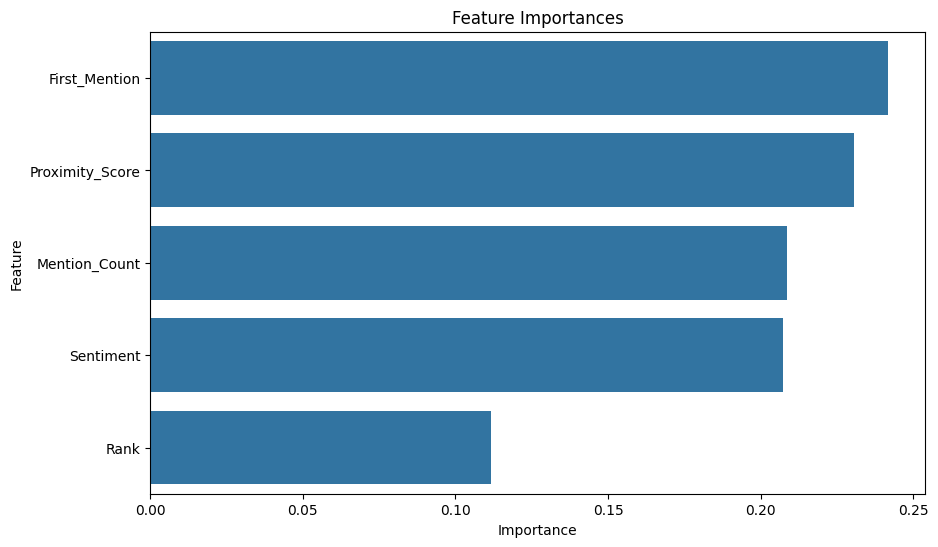

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the model
feature_importances = model.feature_importances_
feature_names = features

# Create a DataFrame
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances)
plt.title('Feature Importances')
plt.show()


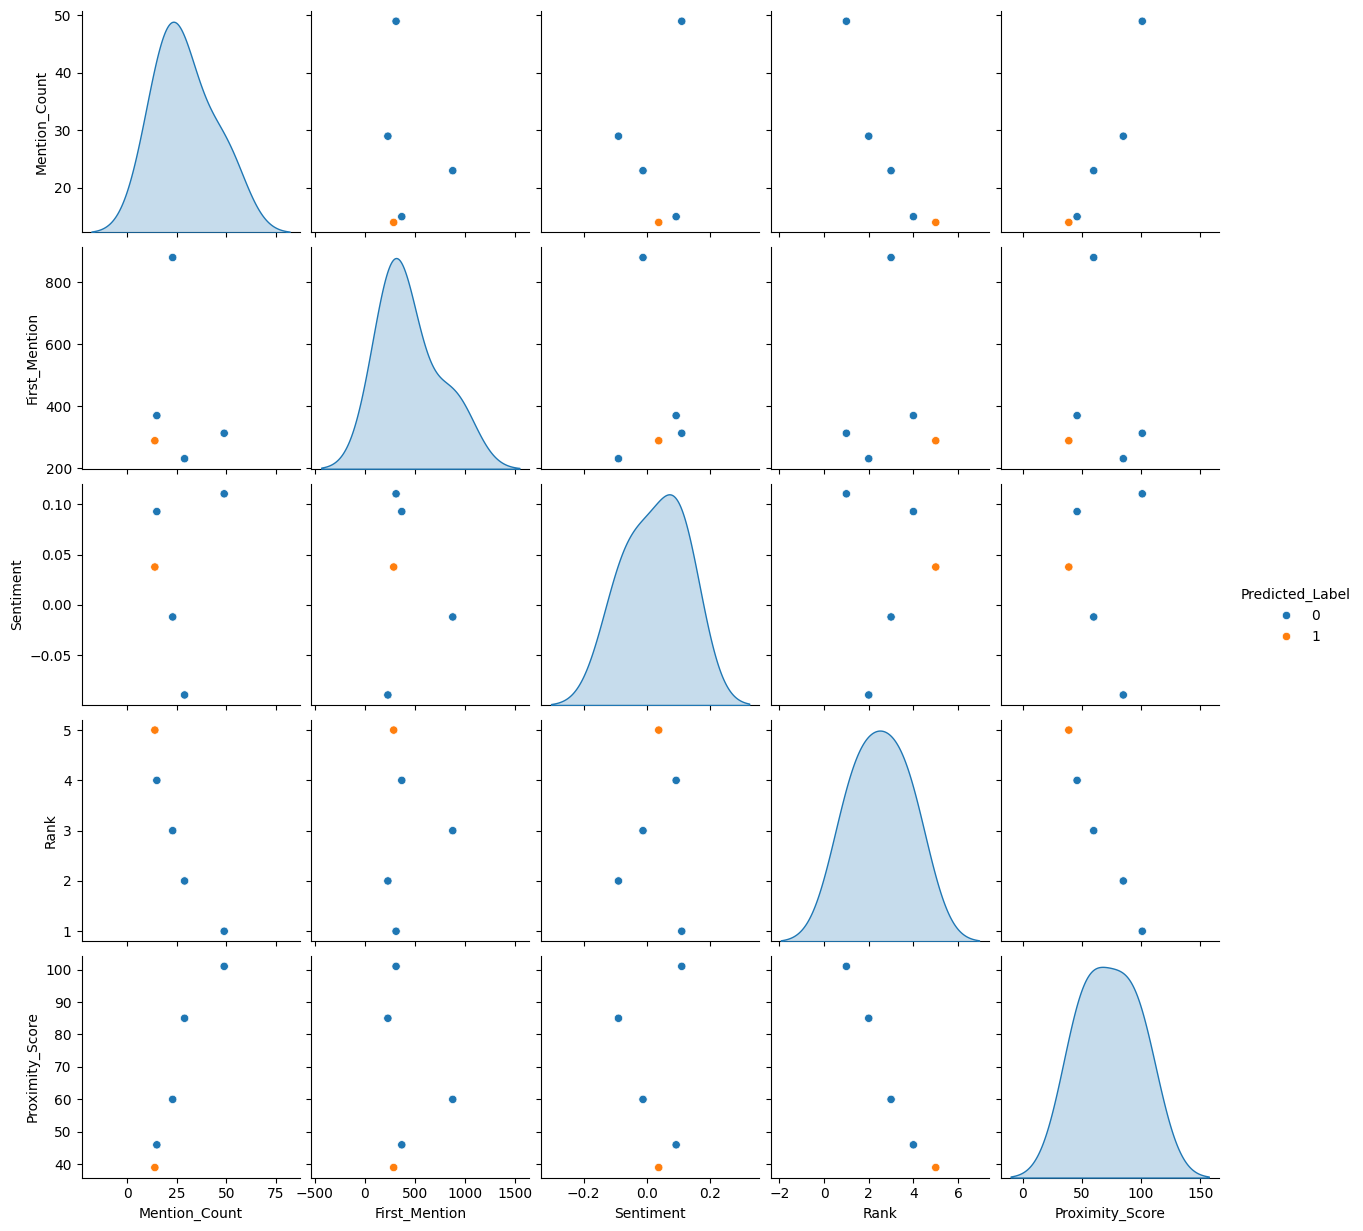

In [12]:
# Compare feature distributions
sns.pairplot(new_story_df, vars=features, hue='Predicted_Label')
plt.show()


In [13]:
# Count the number of events each character is involved in
character_event_counts = {}
for event in new_book.events:
    for character in event['characters']:
        character_event_counts[character] = character_event_counts.get(character, 0) + 1

# Add event counts to the DataFrame
new_story_df['Event_Count'] = new_story_df['Character'].apply(lambda x: character_event_counts.get(x, 0))

# Update the features list
features.append('Event_Count')

# Update X_new
X_new = new_story_df[features]
X_new = X_new.fillna(0)
